In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd

import numpy as np
from python_tsp.heuristics import solve_tsp_local_search, solve_tsp_simulated_annealing, solve_tsp_record_to_record
from python_tsp.exact import solve_tsp_branch_and_bound
import time

import matplotlib.pyplot as plt
import contextily as ctx


In [2]:
# Get the graph of Porto
city = ox.geocode_to_gdf('Porto, Portugal')
G = ox.graph_from_polygon(city.geometry.iloc[0], network_type='walk')

In [3]:
# Get the places of worship in Porto
tags = {'amenity': 'place_of_worship'}
churches = ox.features_from_polygon(city.geometry.iloc[0], tags)

In [4]:
churches.head()

geometry                       alt_name  \
element id                                                                     
node    2210643419   POINT (-8.61326 41.1454)  Capela Nossa Senhora da Silva   
        2469033332  POINT (-8.61103 41.14071)                            NaN   
        4395076911  POINT (-8.56674 41.16373)                            NaN   
        4554574479  POINT (-8.60869 41.14215)                            NaN   
        4716522744   POINT (-8.6231 41.14941)                            NaN   

                             amenity      denomination heritage:operator  \
element id                                                                 
node    2210643419  place_of_worship    roman_catholic              dgpc   
        2469033332  place_of_worship    roman_catholic              dgpc   
        4395076911  place_of_worship  jehovahs_witness               NaN   
        4554574479  place_of_worship  jehovahs_witness               NaN   
        4716522744  place_of_worship  jehovahs_witness               NaN   

                                                heritage:website:sipa  \
element id                                                              
node    2210643419  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        2469033332  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        4395076911                                                NaN   
        4554574479                                                NaN   
        4716522744                                                NaN   

                                                       name  \
element id                                                    
node    2210643419       Oratório de Nossa Senhora da Silva   
        2469033332                        Alminhas da Ponte   
        4395076911  Salão do Reino das Testemunhas de Jeová   
        4554574479  Salão do Reino das Testemunhas de Jeová   
        4716522744  Salão do Reino das Testemunhas de Jeová   

                                         protection_title ref:ipa   religion  \
element id                                                                     
node    2210643419  Incluído em Zona Especial de Proteção    5498  christian   
        2469033332                    Interesse Municipal    5539  christian   
        4395076911                                    NaN     NaN  christian   
        4554574479                                    NaN     NaN  christian   
        4716522744                                    NaN     NaN  christian   

                    ... contact:website roof:material roof:orientation  \
element id          ...                                                  
node    2210643419  ...             NaN           NaN              NaN   
        2469033332  ...             NaN           NaN              NaN   
        4395076911  ...             NaN           NaN              NaN   
        4554574479  ...             NaN           NaN              NaN   
        4716522744  ...             NaN           NaN              NaN   

                   addr:housename engineer patron_saint event_annual landuse  \
element id                                                                     
node    2210643419            NaN      NaN          NaN          NaN     NaN   
        2469033332            NaN      NaN          NaN          NaN     NaN   
        4395076911            NaN      NaN          NaN          NaN     NaN   
        4554574479            NaN      NaN          NaN          NaN     NaN   
        4716522744            NaN      NaN          NaN          NaN     NaN   

                   area type  
element id                    
node    2210643419  NaN  NaN  
        2469033332  NaN  NaN  
        4395076911  NaN  NaN  
        4554574479  NaN  NaN  
        4716522744  NaN  NaN  

[5 rows x 115 columns]

É agora necessário escolher só algumas igrejas, verificando se existem no conjunto de dados:

In [5]:
print(sum(churches['name'] == "Sé do Porto"))
print(sum(churches['name'] == "Igreja do Carmo"))
print(sum(churches['name'] == "Igreja dos Carmelitas"))
print(sum(churches['name'] == "Igreja da Lapa"))
print(sum(churches['name'] == "Igreja de São Francisco"))
print(sum(churches['name'] == "Igreja de Santa Clara"))
print(sum(churches['name'] == "Igreja de Nossa Senhora da Conceição"))
print(sum(churches['name'] == "Igreja do Senhor do Bonfim"))
print(sum(churches['name'] == "Igreja Paroquial de Santo Ildefonso"))
print(sum(churches['name'] == "Igreja dos Clérigos"))

1
1
1
1
1
1
1
1
1
1


estranhamente existem duas igrejas dos Clérigos, filtrando o conjunto de dados

In [6]:
selected_names = [
    "Sé do Porto",
    "Igreja do Carmo",
    "Igreja dos Carmelitas",
    "Igreja da Lapa",
    "Igreja de São Francisco",
    "Igreja de Santa Clara",
    "Igreja de Nossa Senhora da Conceição",
    "Igreja do Senhor do Bonfim",
    "Igreja Paroquial de Santo Ildefonso",
    "Igreja dos Clérigos"
]

# Filter the DataFrame for the selected church names
filtered_churches = churches[churches['name'].isin(selected_names)]

filtered_churches

geometry  \
element id                                                             
way     128828528  POLYGON ((-8.61236 41.15722, -8.61235 41.15721...   
        210461448  POLYGON ((-8.61119 41.14287, -8.61119 41.14293...   
        210681249  POLYGON ((-8.61601 41.14104, -8.61601 41.14102...   
        213578739  POLYGON ((-8.60661 41.14606, -8.60643 41.14623...   
        223780953  POLYGON ((-8.6142 41.1457, -8.61412 41.14572, ...   
        227716463  POLYGON ((-8.60559 41.16133, -8.60562 41.16128...   
        229772731  POLYGON ((-8.61617 41.14733, -8.61626 41.14733...   
        229772732  POLYGON ((-8.61634 41.14732, -8.61636 41.14732...   
        238893532  POLYGON ((-8.60944 41.14251, -8.60937 41.14262...   
        391839915  POLYGON ((-8.59312 41.15131, -8.59273 41.15154...   

                                                            alt_name  \
element id                                                             
way     128828528                                                NaN   
        210461448  Catedral do Porto;Sé Catedral;Sé Catedral do P...   
        210681249                Igreja do Convento de São Francisco   
        213578739                          Igreja de Santo Ildefonso   
        223780953                   Igreja de São Pedro dos Clérigos   
        227716463  Igreja da Senhora da Conceição;Igreja da Nossa...   
        229772731  Igreja da Venerável Ordem Terceira de Nossa Se...   
        229772732                    Igreja dos Carmelitas Descalços   
        238893532  Igreja do Dispensário Rainha Dona Amélia;Igrej...   
        391839915                                                NaN   

                            amenity    denomination heritage:operator  \
element id                                                              
way     128828528  place_of_worship  roman_catholic              dgpc   
        210461448  place_of_worship  roman_catholic              dgpc   
        210681249  place_of_worship  roman_catholic              dgpc   
        213578739  place_of_worship  roman_catholic              dgpc   
        223780953  place_of_worship  roman_catholic               NaN   
        227716463  place_of_worship  roman_catholic              dgpc   
        229772731  place_of_worship  roman_catholic              dgpc   
        229772732  place_of_worship  roman_catholic              dgpc   
        238893532  place_of_worship  roman_catholic              dgpc   
        391839915  place_of_worship  roman_catholic               NaN   

                                               heritage:website:sipa  \
element id                                                             
way     128828528  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        210461448  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        210681249  http://monumentos.pt/Site/APP_PagesUser/SIPA.a...   
        213578739  www.monumentos.gov.pt/Site/APP_PagesUser/SIPA....   
        223780953                                                NaN   
        227716463  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        229772731  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        229772732  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        238893532  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        391839915                                                NaN   

                                                   name  \
element id                                                
way     128828528                        Igreja da Lapa   
        210461448                           Sé do Porto   
        210681249               Igreja de São Francisco   
        213578739   Igreja Paroquial de Santo Ildefonso   
        223780953                   Igreja dos Clérigos   
        227716463  Igreja de Nossa Senhora da Conceição   
        229772731                       Igreja do Carmo   
        229772732                 Igreja dos Carmelitas  

e removendo a linha repetida

In [7]:
# Remove duplicate entries for 'Igreja dos Clérigos'
filtered_churches = filtered_churches.drop_duplicates(subset='name', keep='first')

filtered_churches

geometry  \
element id                                                             
way     128828528  POLYGON ((-8.61236 41.15722, -8.61235 41.15721...   
        210461448  POLYGON ((-8.61119 41.14287, -8.61119 41.14293...   
        210681249  POLYGON ((-8.61601 41.14104, -8.61601 41.14102...   
        213578739  POLYGON ((-8.60661 41.14606, -8.60643 41.14623...   
        223780953  POLYGON ((-8.6142 41.1457, -8.61412 41.14572, ...   
        227716463  POLYGON ((-8.60559 41.16133, -8.60562 41.16128...   
        229772731  POLYGON ((-8.61617 41.14733, -8.61626 41.14733...   
        229772732  POLYGON ((-8.61634 41.14732, -8.61636 41.14732...   
        238893532  POLYGON ((-8.60944 41.14251, -8.60937 41.14262...   
        391839915  POLYGON ((-8.59312 41.15131, -8.59273 41.15154...   

                                                            alt_name  \
element id                                                             
way     128828528                                                NaN   
        210461448  Catedral do Porto;Sé Catedral;Sé Catedral do P...   
        210681249                Igreja do Convento de São Francisco   
        213578739                          Igreja de Santo Ildefonso   
        223780953                   Igreja de São Pedro dos Clérigos   
        227716463  Igreja da Senhora da Conceição;Igreja da Nossa...   
        229772731  Igreja da Venerável Ordem Terceira de Nossa Se...   
        229772732                    Igreja dos Carmelitas Descalços   
        238893532  Igreja do Dispensário Rainha Dona Amélia;Igrej...   
        391839915                                                NaN   

                            amenity    denomination heritage:operator  \
element id                                                              
way     128828528  place_of_worship  roman_catholic              dgpc   
        210461448  place_of_worship  roman_catholic              dgpc   
        210681249  place_of_worship  roman_catholic              dgpc   
        213578739  place_of_worship  roman_catholic              dgpc   
        223780953  place_of_worship  roman_catholic               NaN   
        227716463  place_of_worship  roman_catholic              dgpc   
        229772731  place_of_worship  roman_catholic              dgpc   
        229772732  place_of_worship  roman_catholic              dgpc   
        238893532  place_of_worship  roman_catholic              dgpc   
        391839915  place_of_worship  roman_catholic               NaN   

                                               heritage:website:sipa  \
element id                                                             
way     128828528  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        210461448  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        210681249  http://monumentos.pt/Site/APP_PagesUser/SIPA.a...   
        213578739  www.monumentos.gov.pt/Site/APP_PagesUser/SIPA....   
        223780953                                                NaN   
        227716463  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        229772731  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        229772732  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        238893532  http://www.monumentos.gov.pt/Site/APP_PagesUse...   
        391839915                                                NaN   

                                                   name  \
element id                                                
way     128828528                        Igreja da Lapa   
        210461448                           Sé do Porto   
        210681249               Igreja de São Francisco   
        213578739   Igreja Paroquial de Santo Ildefonso   
        223780953                   Igreja dos Clérigos   
        227716463  Igreja de Nossa Senhora da Conceição   
        229772731                       Igreja do Carmo   
        229772732                 Igreja dos Carmelitas  

# Calculando a matriz de distâncias

In [8]:
def calculate_distance_matrix(gdf, G):
    """
    Calculate the distance matrix for a set of objects within a GeoDataFrame using a specified road network graph.

    Parameters:
    gdf (GeoDataFrame): A GeoPandas GeoDataFrame containing the objects with their geographic data.
                        The GeoDataFrame must have an 'index' with unique identifiers for each object
                        and a 'geometry' column with Point geometries.
    G (Graph): An OSMnx graph representing the road network.

    Returns:
    DataFrame: A pandas DataFrame representing the distance matrix, where each cell [i, j]
               contains the shortest path length between object i and object j.
    """
    # Initialize an empty matrix
    dist_matrix = pd.DataFrame(index=gdf.index, columns=gdf.index)

    # Fill the diagonal with zeros
    np.fill_diagonal(dist_matrix.values, 0)

    for i in gdf.index:
        for j in gdf.index:
            if i != j:
                # Get the shortest path between the two nodes
                origin = (gdf.loc[i, 'geometry'].centroid.y, gdf.loc[i, 'geometry'].centroid.x)
                destination = (gdf.loc[j, 'geometry'].centroid.y, gdf.loc[j, 'geometry'].centroid.x)
                orig_node = ox.nearest_nodes(G, origin[1], origin[0])
                dest_node = ox.nearest_nodes(G, destination[1], destination[0])
                try:
                    shortest_path = nx.shortest_path_length(G, orig_node, dest_node, weight='length')
                    dist_matrix.loc[i, j] = shortest_path
                except nx.NetworkXNoPath:
                    dist_matrix.loc[i, j] = float('inf')

    return dist_matrix

# Example usage:
# Assuming 'gdf' is your GeoDataFrame with the selected objects and their geometries
# 'G' is your graph object from OSMnx
# distance_matrix = calculate_distance_matrix(gdf, G)

In [9]:
dist_matrix = calculate_distance_matrix(filtered_churches, G)

dist_matrix

element                    way                                         \
id                   128828528    210461448    210681249    213578739   
element id                                                              
way     128828528            0  1829.907752  2134.821742  1699.766564   
        210461448  1829.907752            0   657.738307   588.112428   
        210681249  2134.821742   657.738307            0  1203.035127   
        213578739  1699.766564   588.112428  1203.035127            0   
        223780953   1443.26378   536.209554    816.57755   810.749051   
        227716463   980.136366  2427.492332  2840.982252   2161.73883   
        229772731  1212.132439   847.414323  1008.035993  1098.797415   
        229772732  1212.132439   847.414323  1008.035993  1098.797415   
        238893532  2001.655777   328.465583   956.655996   624.004581   
        391839915   2181.44851  1903.593957  2518.516656  1343.234443   

element                                                                \
id                   223780953    227716463    229772731    229772732   
element id                                                              
way     128828528   1443.26378   980.136366  1212.132439  1212.132439   
        210461448   536.209554  2427.492332   847.414323   847.414323   
        210681249    816.57755  2840.982252  1008.035993  1008.035993   
        213578739   810.749051   2161.73883  1098.797415  1098.797415   
        223780953            0  2231.059832     328.9344     328.9344   
        227716463  2231.059832            0  2162.572949  2162.572949   
        229772731     328.9344  2162.572949            0            0   
        229772732     328.9344  2162.572949            0            0   
        238893532   797.483592  2599.240357  1108.688361  1108.688361   
        391839915  2097.507723  1864.878541  2227.919287  2227.919287   

element                                      
id                   238893532    391839915  
element id                                   
way     128828528  2001.655777   2181.44851  
        210461448   328.465583  1903.593957  
        210681249   956.655996  2518.516656  
        213578739   624.004581  1343.234443  
        223780953   797.483592  2097.507723  
        227716463  2599.240357  1864.878541  
        229772731  1108.688361  2227.919287  
        229772732  1108.688361  2227.919287  
        238893532            0  1822.922939  
        391839915  1822.922939            0

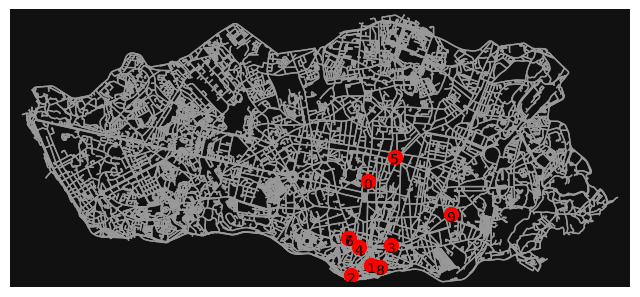

In [10]:
# Plot the graph
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)

# Being the order
i = 0

# Plot each point from the dataframe
for geometry in filtered_churches['geometry']:
    ax.scatter(geometry.centroid.x, geometry.centroid.y, c='red', s=100)
    ax.annotate(i, (geometry.centroid.x, geometry.centroid.y), textcoords="offset points", xytext=(0,-5), ha='center')
    i += 1

# Show the plot
plt.show()

# Methods aplication

In [11]:
new_dist = dist_matrix.to_numpy()

new_dist

array([[0, np.float64(1829.9077524935599),
        np.float64(2134.8217418118784), np.float64(1699.7665644653648),
        np.float64(1443.263780037607), np.float64(980.136365548798),
        np.float64(1212.1324394524386), np.float64(1212.1324394524386),
        np.float64(2001.6557769487029), np.float64(2181.4485102011167)],
       [np.float64(1829.9077524935597), 0, np.float64(657.7383073779384),
        np.float64(588.1124277086869), np.float64(536.2095543482084),
        np.float64(2427.4923324823712), np.float64(847.414323086648),
        np.float64(847.414323086648), np.float64(328.4655832717041),
        np.float64(1903.5939565750464)],
       [np.float64(2134.8217418118784), np.float64(657.7383073779382), 0,
        np.float64(1203.0351272346973), np.float64(816.5775499675535),
        np.float64(2840.9822524086017), np.float64(1008.0359925449297),
        np.float64(1008.0359925449297), np.float64(956.6559961019019),
        np.float64(2518.516656101056)],
       [np.float64(

In [12]:
best_distance = float("inf")

start = time.time()
for i in range(10):
    for j in range(10):
        dist_test = np.delete(new_dist, (i), axis=0)
        dist_test = np.delete(dist_test, (i), axis=1)
        if j!=0:
            dist_test = np.delete(dist_test, (j-1), axis=1)
            dist_test = np.delete(dist_test, (j-1), axis=0)
        if j==0:
            dist_test = np.delete(dist_test, (j), axis=1)
            dist_test = np.delete(dist_test, (j), axis=0)
        permutation, distance = solve_tsp_local_search(dist_test)
        if distance < best_distance:
            best_distance = distance
            best_permutation = permutation
            comb_retirada = np.array([i, j])
end = time.time()

print("Local Search:", best_distance, comb_retirada, best_permutation)
print("Tempo de execução:", round(end-start,2), "secs")

Local Search: 5667.619426176596 [9 6] [0, 3, 7, 1, 2, 4, 6, 5]
Tempo de execução: 0.08 secs


In [13]:
best_distance = float("inf")

start = time.time()
for i in range(10):
    for j in range(10):
        dist_test = np.delete(new_dist, (i), axis=0)
        dist_test = np.delete(dist_test, (i), axis=1)
        if j!=0:
            dist_test = np.delete(dist_test, (j-1), axis=1)
            dist_test = np.delete(dist_test, (j-1), axis=0)
        if j==0:
            dist_test = np.delete(dist_test, (j), axis=1)
            dist_test = np.delete(dist_test, (j), axis=0)
        permutation, distance = solve_tsp_simulated_annealing(dist_test)
        if distance < best_distance:
            best_distance = distance
            best_permutation = permutation
            comb_retirada = np.array([i, j])
end = time.time()

print("Simulated Annealing:", best_distance, comb_retirada, best_permutation)
print("Tempo de execução:", round(end-start,2), "secs")

Simulated Annealing: 5667.619426176596 [5 9] [0, 3, 7, 1, 2, 4, 5, 6]
Tempo de execução: 35.79 secs


In [14]:
best_distance = float("inf")

start = time.time()
for i in range(10):
    for j in range(10):
        dist_test = np.delete(new_dist, (i), axis=0)
        dist_test = np.delete(dist_test, (i), axis=1)
        if j!=0:
            dist_test = np.delete(dist_test, (j-1), axis=1)
            dist_test = np.delete(dist_test, (j-1), axis=0)
        if j==0:
            dist_test = np.delete(dist_test, (j), axis=1)
            dist_test = np.delete(dist_test, (j), axis=0)
        permutation, distance = solve_tsp_branch_and_bound(dist_test)
        if distance < best_distance:
            best_distance = distance
            best_permutation = permutation
            comb_retirada = np.array([i, j])
end = time.time()

print("Branch & Bound:", best_distance, comb_retirada, best_permutation)
print("Tempo de execução:", round(end-start,2), "secs")

Branch & Bound: 5667.619426176597 [5 9] [0, 3, 7, 1, 2, 4, 5, 6]
Tempo de execução: 0.89 secs


# Representing the best route 

In [20]:
# The indices that were removed from the matrix
removed_indices = comb_retirada

# The best route found by the TSP (based on the modified matrix)
route_indices = best_permutation

# Initialize an empty list to store the updated indices
updated_route_indices = []

# For each index in the route
for index in route_indices:
    # Count the number of removed indices that are less than the current index
    count = sum(1 for removed_index in removed_indices if removed_index <= index)
    
    # Add the count to the current index to get the updated index
    updated_index = index + count
    
    # Add the updated index to the list of updated indices
    updated_route_indices.append(updated_index)

print(updated_route_indices)


[0, 3, 8, 1, 2, 4, 6, 7]


In [21]:

# Initialize an empty list to store the nodes of the route
route_nodes = []

# For each index in the route
for i in updated_route_indices:
    geo_col = filtered_churches.columns.get_loc('geometry')
    # Get the origin coordinates

    coords = (filtered_churches.iloc[i, geo_col].centroid.y, filtered_churches.iloc[i, geo_col].centroid.x)

    # Find the nearest node and add it to the route
    route_nodes.append(ox.nearest_nodes(G, coords[1], coords[0]))

# Initialize an empty list to store the paths between the nodes
paths = []

# For each pair of nodes in the route
for i in range(len(route_nodes) - 1):
    # Find the shortest path between the nodes
    path = ox.shortest_path(G, route_nodes[i], route_nodes[i+1])
    
    # Remove the last node of the path (except for the last path)
    if i < len(route_nodes) - 2:
        path = path[:-1]
    
    # Add the path to the paths
    paths.extend(path)

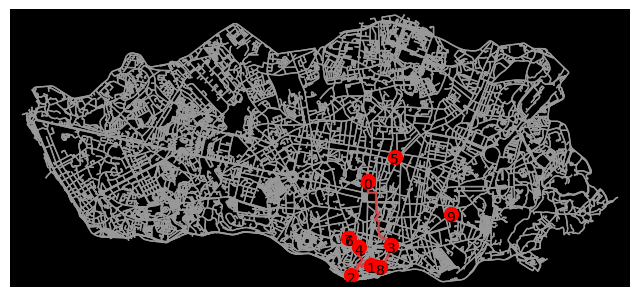

In [22]:
# Plot the route
# ox.plot_graph_route(G, paths, route_color='green', route_linewidth=2, node_size=0, bgcolor='k')
fig, ax = ox.plot_graph_route(G, paths, route_linewidth=2, node_size=0, bgcolor='k', show=False, close=False)

# Plot each point from the dataframe
for i, geometry in enumerate(filtered_churches['geometry']):
    ax.scatter(geometry.centroid.x, geometry.centroid.y, c='red', s=100)
    ax.annotate(i, (geometry.centroid.x, geometry.centroid.y), textcoords="offset points", xytext=(0,-5), ha='center')

# Show the plot
plt.show()

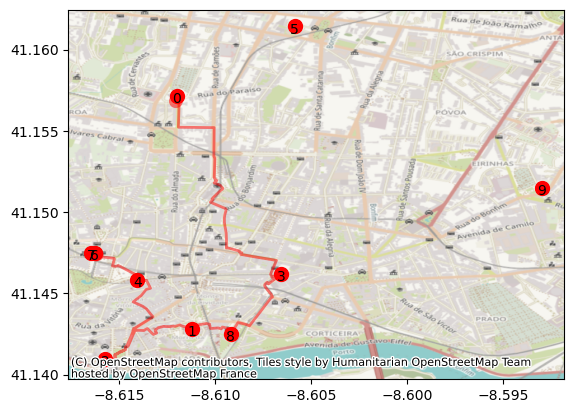

In [23]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the route
# ox.plot_graph_route(G, paths, route_color='green', route_linewidth=2, node_size=0, bgcolor='k')
ox.plot_graph_route(G, paths, route_linewidth=2, node_size=0, bgcolor='k', ax=ax, show=False, close=False)

# Plot each point from the dataframe
for i, geometry in enumerate(filtered_churches['geometry']):
    ax.scatter(geometry.centroid.x, geometry.centroid.y, c='red', s=100)
    ax.annotate(i, (geometry.centroid.x, geometry.centroid.y), textcoords="offset points", xytext=(0,-5), ha='center')

# Add basemap
ctx.add_basemap(ax, crs=G.graph['crs'])

# Show the plot
plt.show()

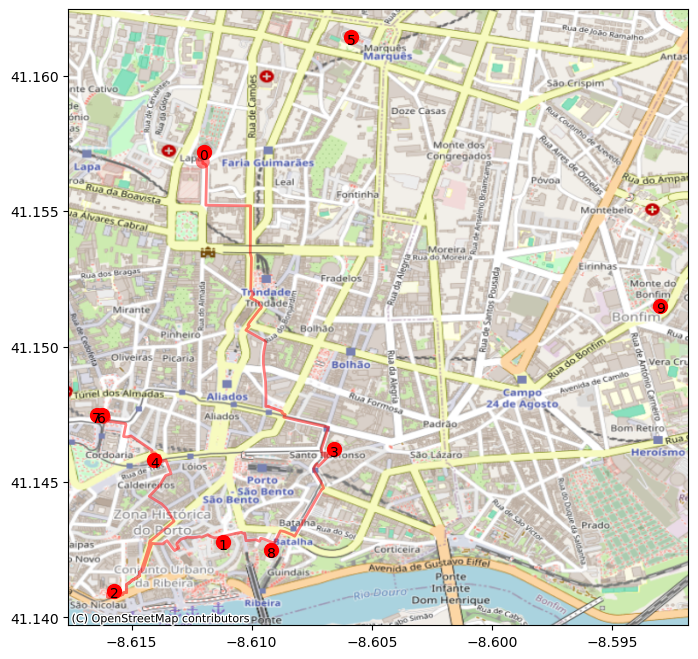

In [24]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8,8))

# Plot the route
# ox.plot_graph_route(G, paths, route_color='green', route_linewidth=2, node_size=0, bgcolor='k')
ox.plot_graph_route(G, paths, route_linewidth=2, node_size=0, bgcolor='k', ax=ax, show=False, close=False)

# Plot each point from the dataframe
for i, geometry in enumerate(filtered_churches['geometry']):
    ax.scatter(geometry.centroid.x, geometry.centroid.y, c='red', s=100)
    ax.annotate(i, (geometry.centroid.x, geometry.centroid.y), textcoords="offset points", xytext=(0,-5), ha='center')

# Add basemap
ctx.add_basemap(ax, crs=G.graph['crs'], source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()